# Maximum consecutive MPID
MPID is already calculated as part of the information in `tableau_pixel_info.ipynb`. The reason that we calculate MPID again in this notebook and make contour map is to avoid more complexity to the other notebook  
This notebook calculates the maximum consecutive must plug in days (MPID), draws a contour map and save the map to a geojson file that will later be read by Tableau

**Before running: `pip install geojsoncontour`**

In [1]:
import sys
sys.path.append('..')

import os

import geojsoncontour
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ev_temp_map.utils import get_lat_lon_mask
from ev_temp_map.utils import get_temperature

## Count maximum consecutive MPID
Define some constants

In [2]:
DATA_FILE_DIR = "./data/nasa/"

START_YEAR, END_YEAR = 2010, 2020

NUM_OF_YEARS = END_YEAR - START_YEAR

NUM_OF_MONTHS = 12

NUM_OF_DAYS = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

The source data format is `netCDF4`.  
First, We need to use any of the source files to extract latitudes, longitudes and land-ocean mask

In [3]:
LAT, LON, MASK = get_lat_lon_mask(DATA_FILE_DIR+"20200101.nc4")

Count the max consec MPID  
Algorithm: Keep two counters. One records the current consec MPID, and the other records the max consec MPID it has seen so far. After counting one day's MPID, compare the two and keep the larger one. Use `np.where` to adapt this algo to count on arrays  
NOTE: `<timed exec>:14: RuntimeWarning: invalid value encountered in less` is due to `nan` values, which we can safely ignore

In [4]:
%%time
# max_MPID will record the max MPID of all places
max_MPID = np.ndarray(shape=(len(LAT), len(LON)))
# curr_MPID will count the consecutive MPID we have seen so far (the counter)
curr_MPID = np.ndarray(shape=(len(LAT), len(LON)))

for year in range(START_YEAR, END_YEAR):
    print(year, end=' ')
    for month in range(1, NUM_OF_MONTHS+1):
        for day in range(1, NUM_OF_DAYS[month]+1):
            date = "{}{:02d}{:02d}".format(year, month, day)
            filepath = DATA_FILE_DIR + date + '.nc4'
            date_temp = get_temperature(filepath)
            
            # if this place has MPID on this day (temp<253.15K),
            # then curr_MPID+1
            # else, this place has no MPID on this day, which means not
            # consecutive, so we reset the counter to 0;
            curr_MPID = np.where(date_temp < 253.15, curr_MPID+1, 0)
            # this is equivalent to A = max(A, B)
            max_MPID = np.where(curr_MPID > max_MPID, curr_MPID, max_MPID)
            
print("Finished!\n")

2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 Finished!

Wall time: 2min 52s


Take a look at the `max_MPID`

In [5]:
max_MPID

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We can only see zeros because those are the sea. We use the mask that we extract in the beginning to filter data

In [6]:
# we have to specify `dtype=float` because the fill_value `np.nan` is a special floating point value
max_MPID = np.ma.array(max_MPID, dtype=float, mask=MASK, fill_value=np.nan)

In [7]:
# max consec MPID of the last 10 years on the Earth
max_MPID.max()

255.0

In [8]:
# get the location of the place that has max consec MPID of the last 10 years on the Earth
# it is in the middle of Greenland if you search for this location in Google map :)
max_loc = np.argmax(max_MPID)
max_lat = max_loc // len(LON)
max_lon = max_loc % len(LAT)
print('Location: ({}, {})'.format(LAT[max_lat], LON[max_lon]))

Location: (80.125, -41.375)


## Draw the contour map

In [9]:
# levels to draw contour lines at
levels = [-1, 0, 1, 7, 14, 30, 60, 90, 120, 150, 180, 210, 240, 270]

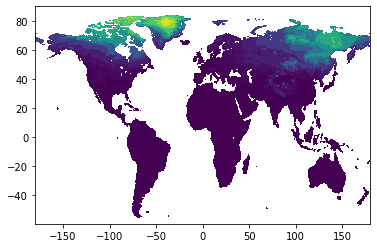

In [10]:
# mesh x and y (lon and lat coordinates)
x_mesh, y_mesh = np.meshgrid(LON, LAT)

# z_mesh
z_mesh = max_MPID

# create the contour plot
# the color of the map doesn't matter as long as the contours are correct,
# because Tableau won't read any color information
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, linestyles="None", levels=levels)

save the map in geojson format

In [11]:
os.makedirs("./geojson_files", exist_ok=True)
geojsoncontour.contourf_to_geojson(contourf, geojson_filepath="./geojson_files/max_consec_MPID.geojson")